# Fraud Detection Analysis
This notebook loads the dataset, cleans and preprocesses data, builds a fraud prediction model, evaluates it, and identifies key factors predicting fraudulent transactions.

In [ ]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns

file_path = r"C:\Users\abhis\Downloads\Fraud.csv" 
data = pd.read_csv(file_path)
print("Original columns:\n", data.dtypes)
print(data.head())


Original columns:
 step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553

In [3]:

# Drop non-numeric ID columns
drop_cols = ['nameOrig','nameDest']
df = data.drop(columns=drop_cols, errors='ignore')

# One-hot encode 'type' column
if 'type' in df.columns:
    df = pd.get_dummies(df, columns=['type'], drop_first=True)

# Convert all columns to numeric and remove inf/NAN
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.replace([np.inf, -np.inf], np.nan).dropna()

print("After cleaning, shape:", df.shape)
print(df.head())


After cleaning, shape: (6362620, 12)
   step    amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0     1   9839.64       170136.0       160296.36             0.0   
1     1   1864.28        21249.0        19384.72             0.0   
2     1    181.00          181.0            0.00             0.0   
3     1    181.00          181.0            0.00         21182.0   
4     1  11668.14        41554.0        29885.86             0.0   

   newbalanceDest  isFraud  isFlaggedFraud  type_CASH_OUT  type_DEBIT  \
0             0.0        0               0          False       False   
1             0.0        0               0          False       False   
2             0.0        1               0          False       False   
3             0.0        1               0           True       False   
4             0.0        0               0          False       False   

   type_PAYMENT  type_TRANSFER  
0          True          False  
1          True          False  
2         False 

In [4]:

# VIF calculation
target = 'isFraud'
X = df.drop(columns=[target])

vif = pd.DataFrame()
vif['feature'] = X.columns

def safe_vif(values, idx):
    try:
        return variance_inflation_factor(values, idx)
    except Exception as e:
        print(f"Skipping {X.columns[idx]} due to: {e}")
        return np.nan

vif['VIF'] = [safe_vif(X.values, i) for i in range(X.shape[1])]
vif.sort_values('VIF', ascending=False, inplace=True)
vif


Skipping step due to: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
Skipping amount due to: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
Skipping oldbalanceOrg due to: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
Skipping newbalanceOrig due to: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
Skipping oldbalanceDest due to: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
Skipping newbalanceDest due to: ufunc 'isfinite' not supported for the inp

,feature,VIF
0,step,NaN
1,amount,NaN
2,oldbalanceOrg,NaN
3,newbalanceOrig,NaN
4,oldbalanceDest,NaN
5,newbalanceDest,NaN
6,isFlaggedFraud,NaN
7,type_CASH_OUT,NaN
8,type_DEBIT,NaN
9,type_PAYMENT,NaN


In [5]:

y = df[target]
X = df.drop(columns=[target])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Training set:", X_train.shape)
print("Test set:", X_test.shape)


Training set: (5090096, 11)
Test set: (1272524, 11)


In [6]:

# Train RandomForestClassifier
clf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:,1]


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99   1270881
           1       0.08      0.99      0.14      1643

    accuracy                           0.98   1272524
   macro avg       0.54      0.99      0.57   1272524
weighted avg       1.00      0.98      0.99   1272524



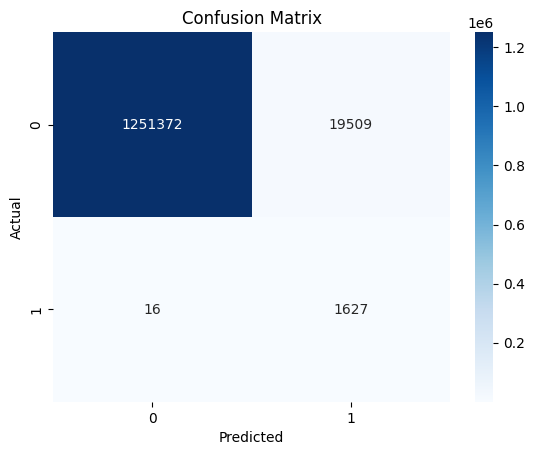

ROC AUC Score: 0.9991784912465458


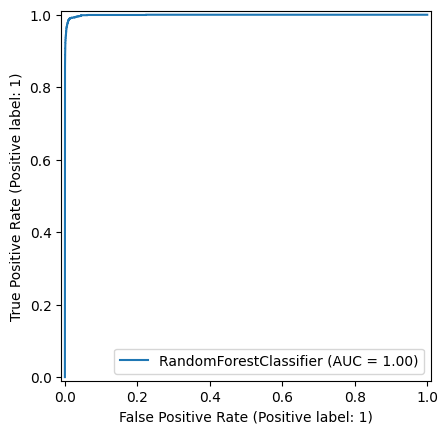

In [7]:

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC AUC
roc_score = roc_auc_score(y_test, y_prob)
print("ROC AUC Score:", roc_score)
RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.show()


Top features:
 oldbalanceOrg     0.302001
newbalanceOrig    0.179531
amount            0.142071
type_TRANSFER     0.095545
type_PAYMENT      0.075977
newbalanceDest    0.055931
step              0.051821
oldbalanceDest    0.049206
type_CASH_OUT     0.047167
isFlaggedFraud    0.000529
dtype: float64


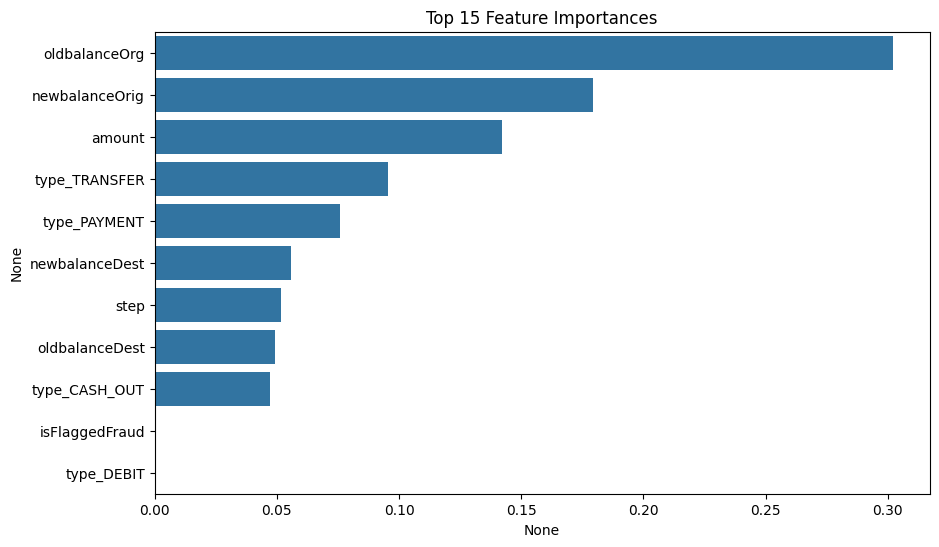

In [9]:
# Feature importance
importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Corrected print statement
print("Top features:\n", importances.head(10))

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=importances.head(15), y=importances.head(15).index)
plt.title("Top 15 Feature Importances")
plt.show()


## Insights & Actionable Plan
- The model identifies transactions with high fraud risk.
- Key factors (feature importance) indicate which transaction attributes are predictive.
- Recommendation: Implement monitoring rules for these high-risk factors and flag suspicious transactions.
- After implementing, track metrics such as false positives, fraud caught, and overall ROC AUC to evaluate effectiveness.